In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 -4*x + 5

In [3]:
f(3.0)

20.0

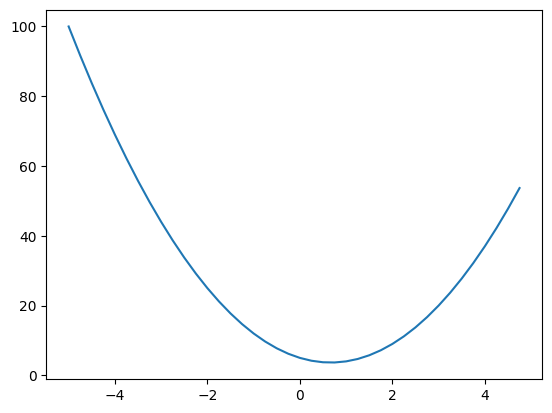

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
h = 0.0000001
x = 2/3
(f(x + h) - f(x)) / h

2.9753977059954195e-07

In [6]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [7]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [8]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [9]:
a = Value(2.0)
b = Value(4.0)
a - 1

Value(data=1.0)

In [10]:
import os
os.environ["PATH"] += os.pathsep + 'C:\Program Files\Graphviz\bin'

In [11]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [12]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

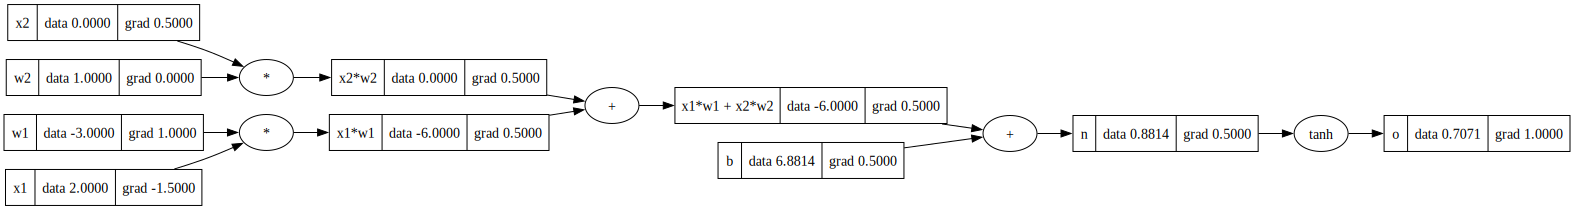

In [13]:
draw_dot(o)

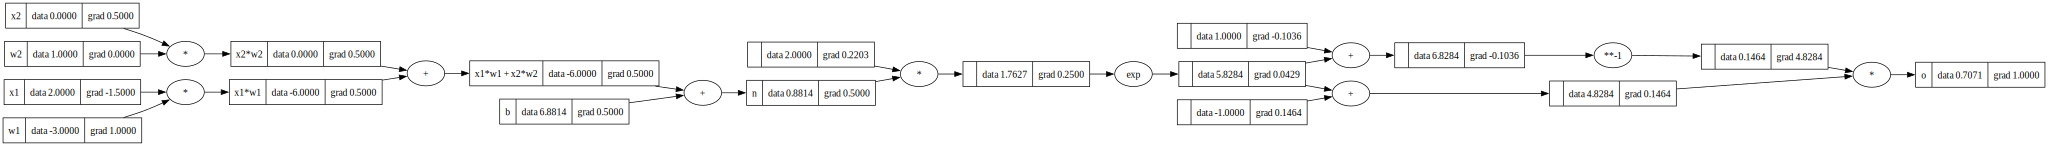

In [14]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# --------------------------------------------------------
e = (2*n).exp()
o = (e - 1) / (e + 1)
# --------------------------------------------------------
o.label = 'o'
o.backward()
draw_dot(o)

In [15]:
import torch

In [16]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [17]:
import random

class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
            return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
  
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [26]:
#init MLP
n = MLP(2, [4, 4, 1])

In [27]:
#rnd data
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [20]:
#xor data
xs = [
  [0.0, 0.0],
  [0.0, 1.0],
  [1.0, 0.0],
  [1.0, 1.0],
]
ys = [-1.0, 1.0, 1.0, -1.0] # desired targets

In [303]:
#init MLP
n = MLP(1, [8, 1])

#sin function data
xs = [[float(x_f/10)] for x_f in range(-60, 60)]
#ys = [1.0 if math.sin(x[0]) > 0 else -1.0 for x in xs]
ys = [math.sin(x[0]) for x in xs]
zs = list(zip(xs, ys))
zs
loss_y = []

99 2.2851526068855024
-------------------
199 2.2839637277460776
-------------------
299 2.282789664156285
-------------------
399 2.2816302100018935
-------------------
499 2.2804851621485946
-------------------
599 2.2793543203940896
-------------------
699 2.2782374874214315
-------------------
799 2.277134468753549
-------------------
899 2.2760450727089467
-------------------
999 2.274969110358431
-------------------
1099 2.2739063954829266
-------------------
1199 2.2728567445322345
-------------------
1299 2.2718199765847427
-------------------
1399 2.270795913308029
-------------------
1499 2.269784378920315
-------------------
1599 2.268785200152728
-------------------
1699 2.2677982062123507
-------------------
1799 2.2668232287459946
-------------------
1899 2.2658601018046935
-------------------
1999 2.2649086618088736
-------------------


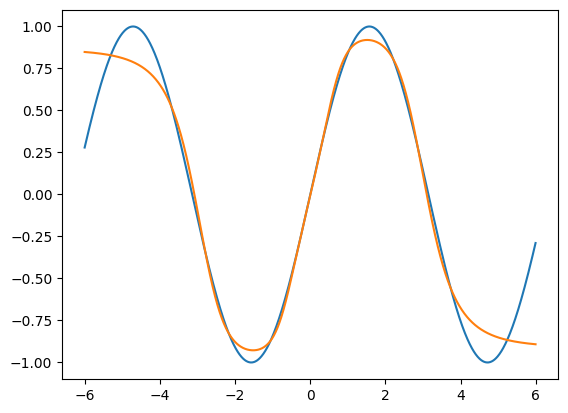

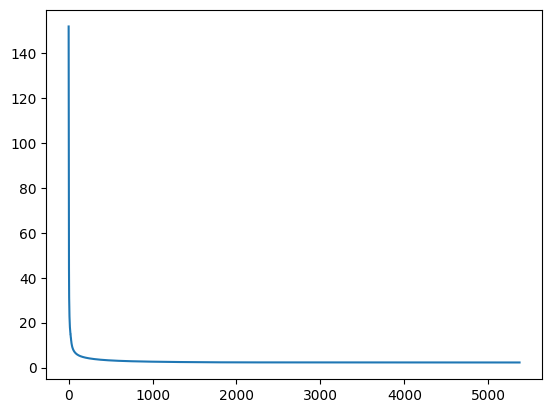

In [306]:
loss_function = plt.figure()
sin_graph = plt.figure()

for l in range(20):
    for k in range(100):
      # forward pass
      ypred = [n(x) for x in xs]
      loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
      
      # backward pass
      for p in n.parameters():
        p.grad = 0.0
      loss.backward()
      
      # update
      for p in n.parameters():
        p.data += -0.0001 * p.grad
      
      #print(k + l*10, loss.data)
      loss_y.append(loss.data)

    #sine wave
    sin_x = [[float(x_f/100)] for x_f in range(-600, 600)]
    sin_y = [math.sin(x[0]) for x in sin_x]
    ai_sin_y = [n(x).data for x in sin_x]

    plt.clf()
    plt.figure(sin_graph.number)
    plt.plot(sin_x, sin_y)
    plt.plot(sin_x, ai_sin_y)
    plt.savefig('sin_graph_approximation' + str(l) + '.png')
    print(k + l*100, loss.data)
    print("-------------------")

#loss function
plt.figure(loss_function.number)
plt.plot([float(x) for x in range(0, len(loss_y), 1)], loss_y)
plt.savefig('loss_function.png')

In [70]:
ypred

[Value(data=0.05623888470330414),
 Value(data=0.11853577573193728),
 Value(data=0.19464748681692887),
 Value(data=0.28348990440577504),
 Value(data=0.38221165957587994),
 Value(data=0.48591163886869226),
 Value(data=0.5879785941837761),
 Value(data=0.6813694421888081),
 Value(data=0.7605107073253787),
 Value(data=0.822781690367188),
 Value(data=0.8686662242749241),
 Value(data=0.9006884956873106),
 Value(data=0.9220246756885224),
 Value(data=0.9355247066433267),
 Value(data=0.9432994805073367),
 Value(data=0.9466756365074791),
 Value(data=0.9462860627516089),
 Value(data=0.9421587306068555),
 Value(data=0.9337562406819249),
 Value(data=0.9199776762302401),
 Value(data=0.8991806420334716),
 Value(data=0.8693240416578226),
 Value(data=0.8283444271728715),
 Value(data=0.7747991341689054),
 Value(data=0.7086090224487301),
 Value(data=0.6315284129913072),
 Value(data=0.5469974452518165),
 Value(data=0.45937463647691457),
 Value(data=0.37293217715820637),
 Value(data=0.2910757874883935)]

0.6982609735333757
0.5141359916531131


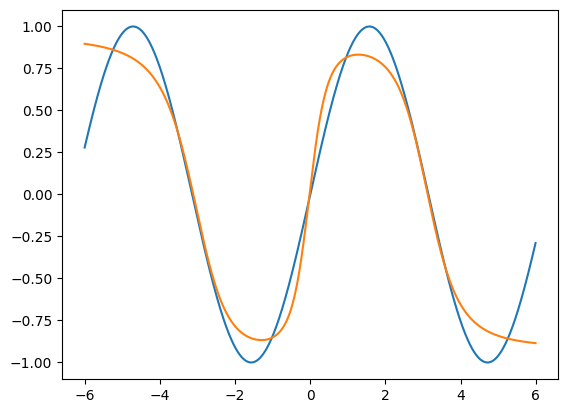

In [205]:
x = [0.54]
print(n(x).data)
print(math.sin(x[0]))

sin_x = [[float(x_f/100)] for x_f in range(-600, 600)]
sin_y = [math.sin(x[0]) for x in sin_x]
ai_sin_y = [n(x).data for x in sin_x]
plt.plot(sin_x, sin_y)
plt.plot(sin_x, ai_sin_y)

In [25]:
zs

[([-10.0], 1.0),
 ([-9.9], 1.0),
 ([-9.8], 1.0),
 ([-9.7], 1.0),
 ([-9.6], 1.0),
 ([-9.5], 1.0),
 ([-9.4], -1.0),
 ([-9.3], -1.0),
 ([-9.2], -1.0),
 ([-9.1], -1.0),
 ([-9.0], -1.0),
 ([-8.9], -1.0),
 ([-8.8], -1.0),
 ([-8.7], -1.0),
 ([-8.6], -1.0),
 ([-8.5], -1.0),
 ([-8.4], -1.0),
 ([-8.3], -1.0),
 ([-8.2], -1.0),
 ([-8.1], -1.0),
 ([-8.0], -1.0),
 ([-7.9], -1.0),
 ([-7.8], -1.0),
 ([-7.7], -1.0),
 ([-7.6], -1.0),
 ([-7.5], -1.0),
 ([-7.4], -1.0),
 ([-7.3], -1.0),
 ([-7.2], -1.0),
 ([-7.1], -1.0),
 ([-7.0], -1.0),
 ([-6.9], -1.0),
 ([-6.8], -1.0),
 ([-6.7], -1.0),
 ([-6.6], -1.0),
 ([-6.5], -1.0),
 ([-6.4], -1.0),
 ([-6.3], -1.0),
 ([-6.2], 1.0),
 ([-6.1], 1.0),
 ([-6.0], 1.0),
 ([-5.9], 1.0),
 ([-5.8], 1.0),
 ([-5.7], 1.0),
 ([-5.6], 1.0),
 ([-5.5], 1.0),
 ([-5.4], 1.0),
 ([-5.3], 1.0),
 ([-5.2], 1.0),
 ([-5.1], 1.0),
 ([-5.0], 1.0),
 ([-4.9], 1.0),
 ([-4.8], 1.0),
 ([-4.7], 1.0),
 ([-4.6], 1.0),
 ([-4.5], 1.0),
 ([-4.4], 1.0),
 ([-4.3], 1.0),
 ([-4.2], 1.0),
 ([-4.1], 1.0),
 ([-4.0